# A Failure Case of VAE

In [15]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.normal import Normal
from torch import optim
import seaborn as sns
color=sns.color_palette()

### Samples from data distribution $p_d(x)$

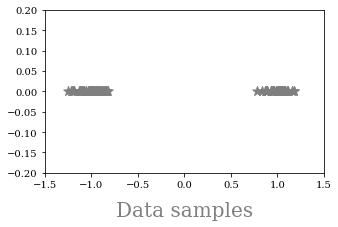

In [635]:
def data_sample(n=100):
    z_dis=Bernoulli(0.5)
    z_sample=2*z_dis.sample([n,1])-1
    a=torch.randn([n,1])*0.1
    x=torch.cat((a+z_sample,torch.zeros_like(a)),1)
    return x


x=data_sample(100)
plt.figure(figsize=(5,3))
plt.ylim(-0.2,0.2)
plt.xlim(-1.5,1.5)
plt.scatter(x[:,0],x[:,1],marker='*',s=100,color=color[7])
plt.title('Data samples', fontsize=20,y=-0.3,c='grey')
plt.show()

In [571]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1=torch.nn.Linear(2, 16)
        self.enc2=torch.nn.Linear(16,1)
        
        self.dec1=torch.nn.Linear(1, 16)
        self.dec2_mean=torch.nn.Linear(16,2)
        self.dec2_std=torch.nn.Linear(16,2)

        
    def encoder(self,x):
        x=F.relu(self.enc1(x))
        return torch.sigmoid(self.enc2(x))

    def decoder(self,z):
        x=F.relu(self.dec1(z))
        return self.dec2_mean(x),F.softplus(self.dec2_std(x))*0.1
        
    def spread_forward(self, x , noise_std=0.01):
        tilde_x=x+torch.randn_like(x)*noise_std
        p = self.encoder(tilde_x)
        mu_0,std_0=self.decoder(torch.zeros([x.size(0),1]))
        mu_1,std_1=self.decoder(torch.ones([x.size(0),1]))
        px_z0=Normal(mu_0,torch.sqrt(std_0**2+noise_std**2))
        px_z1=Normal(mu_1,torch.sqrt(std_1**2+noise_std**2))
        ### evaluation using x is unbinased and lower variance, see Appendix G in https://arxiv.org/pdf/1811.08968.pdf
        elbo=p*px_z1.log_prob(x)+(1-p)*px_z0.log_prob(x)-p*torch.log(p)-(1-p)*torch.log(1-p) 
        return torch.sum(elbo,1).mean()

    def forward(self, x):
        p = self.encoder(x)
        mu_0,std_0=self.decoder(torch.zeros([x.size(0),1]))
        mu_1,std_1=self.decoder(torch.ones([x.size(0),1]))

        px_z0=Normal(mu_0,std_0)
        px_z1=Normal(mu_1,std_1)
        elbo=p*px_z1.log_prob(x)+(1-p)*px_z0.log_prob(x)-p*torch.log(p)-(1-p)*torch.log(1-p)
        return torch.sum(elbo,1).mean()
    
    def sample(self,n):
        z_dis=Bernoulli(0.5)
        z_sample=z_dis.sample([n,1])
        mu,std=self.decoder(z_sample)
        return Normal(mu,std).sample()

#### ELBO
$$\langle\log p_\theta(x|z)+\log p(z)\rangle_{q_\phi(z|x)} + H(q_\phi(z|x)) =\sum_{i=\{0,1\}} q_\phi(z=i|x)\log p_\theta(x|z=i)+H(q_\phi(z|x))+const.$$


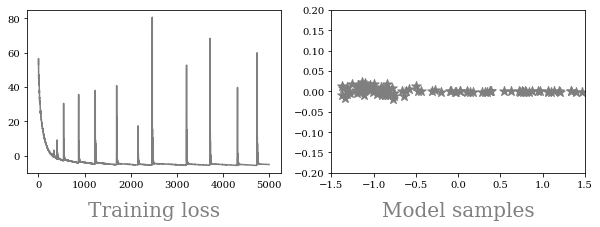

In [626]:
model=VAE()
torch.manual_seed(1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss=[]
for it in range(0,5000):
    x=data_sample(100)
    optimizer.zero_grad()
    L = -model(x)
    L.backward()
    optimizer.step()
    train_loss.append(L.item())
    
    

x=model.sample(100)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,3))
plt.rcParams["font.family"] = 'serif'
ax1.plot(train_loss,color=color[7])
ax1.set_title('Training loss', fontsize=20,y=-0.3,c='grey')
ax2.set_ylim(-0.2,0.2)
ax2.set_xlim(-1.5,1.5)
ax2.scatter(x[:,0],x[:,1],marker='*',s=100,color=color[7])
ax2.set_title('Model samples', fontsize=20,y=-0.3,c='grey')
plt.show()


#### Spread ELBO
$$\langle\log p_\theta(\tilde{x}|z)+\log p(z)\rangle_{q_\phi(z|\tilde{x})} + H(q_\phi(z|\tilde{x})) =\sum_{i=\{0,1\}} q_\phi(z=i|\tilde{x})\log p_\theta(\tilde{x}|z=i)+H(q_\phi(z|\tilde{x}))+const.$$


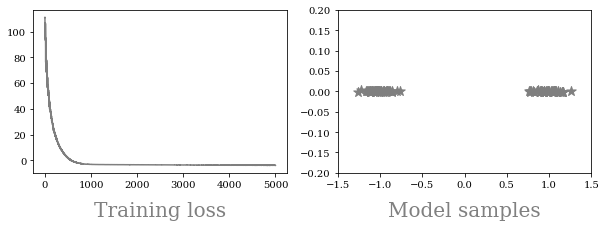

In [627]:
spread_noise_std=0.02
torch.manual_seed(1)

model=VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss=[]
for it in range(0,5000):
    x=data_sample(100)
    optimizer.zero_grad()
    L = -model.spread_forward(x,spread_noise_std)
    L.backward()
    optimizer.step()
    train_loss.append(L.item())
    
x=model.sample(100)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,3))
plt.rcParams["font.family"] = 'serif'
ax1.plot(train_loss,color=color[7])
ax1.set_title('Training loss', fontsize=20,y=-0.3,c='grey')
ax2.set_ylim(-0.2,0.2)
ax2.set_xlim(-1.5,1.5)
ax2.scatter(x[:,0],x[:,1],marker='*',s=100,color=color[7])
ax2.set_title('Model samples', fontsize=20,y=-0.3,c='grey')
plt.show()